In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import resize
import os
from logging import warning
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map, thread_map

ROOT_DIR = Path('..')

# Initial data processing

In [2]:
records = pd.read_excel(ROOT_DIR/Path('data/records.xlsx'))
records=records.rename(columns={'מספר דגימה':'sample_id', 'מספר סלייד':'slide_id', 'מספר טביעה':'fp_position', 'תאריך הטבעה':'imprint_date', 'שעת הטבעה': 'imprint_time',
       'תאריך דגימה':'sample_date', 'שעת דגימה':'sample_time', 'גיל תורם':'donor_age', 'מין תורם':'donor_sex', 'תורם':'donor_name', 'איכות':'quality',
       'הערות':'comments'})
records=records[records['quality'].isna()].drop(columns=['quality'])
bad_samples = [1528]
records=records[~records['sample_id'].isin(bad_samples)]
bad_slides = [156,150,159,149,158]
records=records[~records['slide_id'].isin(bad_slides)]
records =records.drop(columns=['sample_id','donor_age','donor_sex','donor_name','comments'])
records = records.replace('x',np.nan)
records = records.replace('X',np.nan)
records = records.dropna(axis=0,how='any')
records['imprint_full'] = records['imprint_date'].astype(str)+' '+records['imprint_time'].astype(str)
records['sample_full'] = records['sample_date'].astype(str)+' '+records['sample_time'].astype(str)
records = records.drop(columns=['imprint_date','imprint_time','sample_date','sample_time'])
records['imprint_full'] = pd.to_datetime(records['imprint_full'],format='mixed',dayfirst=True,yearfirst=False)
records['sample_full'] = pd.to_datetime(records['sample_full'],format='mixed',dayfirst=True,yearfirst=False)
records['target'] = records['sample_full']-records['imprint_full']
records['target'] = records['target'].dt.total_seconds()/3600/24
records = records.drop(columns=['imprint_full','sample_full'])
records.head()

,slide_id,fp_position,target
32,169,1,1.125000
35,169,4,1.131944
36,169,5,1.131250
37,169,6,0.965278
41,170,2,3.675694


In [3]:
records[records['target']<0]

,slide_id,fp_position,target


In [4]:
from glob import glob
file_names = glob(str(ROOT_DIR/Path('data/raw/*.txt')))
file_names = [os.path.basename(f) for f in file_names]
# file_names

In [5]:
# function that finds where a sequence of _number_number_ is in the string
from typing import Tuple


def is_slide_num(s: str) -> bool:
    return s.isdigit() and  0 < int(s) < 10_000


def find_slide_nums(file_path: str) -> Tuple[int, int]:
    parts = file_path.split("_")
    for i in range(len(parts) - 1):
        if is_slide_num(parts[i]) and is_slide_num(parts[i + 1]):
            return int(parts[i]), int(parts[i + 1])
    assert False, f"Could not find slide numbers in {file_path}"

In [6]:
def add_file_names(records, file_names):
    def find_file_name(row):
        slide_num = int(row['slide_id'])
        fp_pos = int(row['fp_position'])
        slide_files = [file for file in file_names if f'_{slide_num}_' in file]
        if len(slide_files) == 0:
            warning(f'No files found for slide {slide_num} position {fp_pos}')
            return None
        file_slide_nums = [find_slide_nums(file) for file in slide_files]
        first_slide = file_slide_nums[0][0]
        slide_letter = 'A' if first_slide == slide_num else 'B'
        slide_files = [file for file in slide_files if f'_{slide_letter}_' in file]
        file_list = [file for file in slide_files if file.endswith(f'_{fp_pos}.txt')]
        assert len(file_list) == 1, f'{row.name} {slide_files} {file_list} {fp_pos} {slide_num} {slide_letter} {first_slide}'
        file = file_list[0]
        return file
    records['file_name'] = records.apply(find_file_name, axis=1)
    return records


In [7]:
records

,slide_id,fp_position,target
32,169,1,1.125000
35,169,4,1.131944
36,169,5,1.131250
37,169,6,0.965278
41,170,2,3.675694
...,...,...,...
392,181,1,72.134028
394,181,3,70.268056
395,181,4,69.250000
396,181,5,68.140278


In [8]:
records_with_file_names = add_file_names(records, file_names)
records_with_file_names

,slide_id,fp_position,target,file_name
32,169,1,1.125000,lockmass_230924_169_170_Slide_A_1.txt
35,169,4,1.131944,lockmass_230924_169_170_Slide_A_4.txt
36,169,5,1.131250,lockmass_230924_169_170_Slide_A_5.txt
37,169,6,0.965278,lockmass_230924_169_170_Slide_A_6.txt
41,170,2,3.675694,lockmass_230924_169_170_Slide_B_2.txt
...,...,...,...,...
392,181,1,72.134028,lockmass_060525_slide_171_181_N_Slide_B_1.txt
394,181,3,70.268056,lockmass_060525_slide_171_181_N_Slide_B_3.txt
395,181,4,69.250000,lockmass_060525_slide_171_181_N_Slide_B_4.txt
396,181,5,68.140278,lockmass_060525_slide_171_181_N_Slide_B_5.txt


In [9]:
def create_name(row: pd.Series) -> str:
    slide_num = int(row['slide_id'])
    fp_pos = int(row['fp_position'])
    file_name = row['file_name']
    return f'slide_{slide_num}_fp_{fp_pos}_{file_name}'

In [10]:
def load_data(row:pd.Series) -> pd.DataFrame:
    file_name = row['file_name']
    df = pd.read_csv(f'{ROOT_DIR}/data/raw/{file_name}', sep='\t', skiprows=3).reset_index(drop=True).iloc[:,1:]
    cols = df.columns[2:]
    cols = np.array([float(col) for col in cols])
    cols = np.round(cols,1)
    df = df.iloc[:,:-2]
    df.columns = cols
    name = create_name(row)
    df.name = name
    df = df.T.groupby(df.columns).sum().T
    return df

data_list = process_map(load_data, [row for _, row in records_with_file_names.iterrows()], desc="Loading data", unit="file")

Loading data:   0%|          | 0/221 [00:00<?, ?file/s]

In [11]:
masses_list = [data.columns for data in data_list]
masses_sets = [set(masses) for masses in masses_list]
inter_masses = masses_sets[0].intersection(*masses_sets[1:])
inter_masses = list(inter_masses)

data_list_filtered = [data.loc[:,list(inter_masses)] for data in data_list]
data_list_filtered = [df.T.groupby(df.columns).sum().T for df in data_list_filtered]

In [12]:
from typing import List


shapes_list:List[Tuple]=[df.shape for df in data_list_filtered]
# value count shapes
shapes= pd.Series(shapes_list).value_counts()
shapes

(8836, 126)     212
(11236, 126)      8
(8460, 126)       1
Name: count, dtype: int64

In [13]:
from typing import Optional


def resize_dataframe(df:pd.DataFrame,shape:Tuple[int,int]) -> Optional[pd.DataFrame]:
    if df.shape == shape:
        return df
    elif int(np.sqrt(df.shape[0])) != int(np.round(np.sqrt(df.shape[0]))):
        return None
    new_df = pd.DataFrame(columns=df.columns,index=range(shape[0]))
    for i in range(df.shape[1]):
        
        orig_shape = df.shape
        orig_size = int(np.sqrt(orig_shape[0]))
        values = df.iloc[:,i].values.reshape(orig_size,orig_size)
        new_size = int(np.sqrt(shape[0]))
        new_values = resize(values,(new_size,new_size),anti_aliasing=True)
        new_values = new_values.flatten()
        new_df.iloc[:,i] = new_values
    return new_df

In [14]:
most_common_shape = list(shapes.index)[0]
assert isinstance(most_common_shape, tuple), "Most common shape should be a tuple"
assert len(most_common_shape) == 2, "Most common shape should be a tuple of length 2"
resized_data_list = [resize_dataframe(df,most_common_shape) for df in data_list_filtered]

shapes_list=[df.shape for df in resized_data_list if df is not None]
# value count shapes
shapes = pd.Series(shapes_list).value_counts()
shapes

(8836, 126)    220
Name: count, dtype: int64

In [15]:
resized_data_list = [df.T.sort_index().T if df is not None else None for df in resized_data_list]

# get the index of the None elements in the list
none_index = [i for i, df in enumerate(resized_data_list) if df is None]
none_index

[21]

In [16]:
# remove the None elements from the records and the data list
none_index_records = records_with_file_names.index[none_index]
clean_records = records_with_file_names[~records_with_file_names.index.isin(none_index_records)]
resized_data_list = [df for df in resized_data_list if df is not None]
none_index=[]
assert len(clean_records) == len(resized_data_list)

In [17]:
def check_square_shape(df: pd.DataFrame) -> bool:
    """Check if the DataFrame has a square shape."""
    return np.isclose(np.sqrt(df.shape[0]), int(np.sqrt(df.shape[0])))

In [18]:
def create_img(df: pd.DataFrame) -> Optional[np.ndarray]:
    if not check_square_shape(df):
        warning(f"DataFrame {df.name} does not have a square shape. Skipping.")
        return None
    square_length = int(np.sqrt(df.shape[0]))
    img = np.array([df[col].values.astype(np.float64).reshape(square_length,square_length) for col in df.columns])
    img = np.moveaxis(img,0,-1)
    return img

In [19]:
X = np.array(list(process_map(create_img, resized_data_list)))
X.shape

  0%|          | 0/220 [00:00<?, ?it/s]

(220, 94, 94, 126)

In [20]:
def get_masses_list_from_index(index:int,resized_data_list:List[pd.DataFrame]) -> np.ndarray:
    masses_list = resized_data_list[index].columns
    masses = np.array([float(mass) for mass in masses_list])
    return masses


masses_0 = get_masses_list_from_index(0, resized_data_list)
for i, df in enumerate(resized_data_list):
    assert (get_masses_list_from_index(i, resized_data_list) == masses_0).all(), f"Masses mismatch at index {i}"

In [21]:
y = clean_records['target'].values.astype(np.float32)
metadata = clean_records.drop(columns=['target'])

np.save(f'{ROOT_DIR}/data/processed/X.npy',X)
np.save(f'{ROOT_DIR}/data/processed/y.npy',y)
np.save(f'{ROOT_DIR}/data/processed/masses.npy',masses_0)
metadata.to_csv(f'{ROOT_DIR}/data/processed/metadata.csv', index=False)

# EDA

## feature based garbage filtering

In [ ]:
X =  np.load(f'{ROOT_DIR}/data/proccessed/X.npy')
y =  np.load(f'{ROOT_DIR}/data/proccessed/y.npy')
masses=  np.load(f'{ROOT_DIR}/data/proccessed/masses.npy')
assert X.shape[0] == y.shape[0], "X and y must have the same number of samples"


In [ ]:
from skimage import exposure

def normalize_img(img: np.ndarray,min_val: float = -1.0, max_val: float = 1.0) -> np.ndarray:
    img = img.astype(np.float64)
    img_min = np.min(img)
    img_max = np.max(img)
    if img_min == img_max:
        warning(f"Image {img} has no variation, skipping normalization.")
        return img
    img = (img - img_min) / (img_max - img_min) * (max_val - min_val) + min_val
    return img

def clahe(img:np.ndarray)->np.ndarray:
    img = normalize_img(img, min_val=-1.0, max_val=1.0)
    img = exposure.equalize_adapthist(img)
    return img

In [ ]:
import numpy as np
from skimage.feature import structure_tensor
from scipy.ndimage import gaussian_filter

def calc_fft_peak_ratio(image: np.ndarray) -> float:
    """
    Returns the ratio of the strongest non-DC peak to the average spectrum magnitude.
    """
    # compute 2D FFT magnitude
    F = np.fft.fft2(image)
    mag = np.abs(np.fft.fftshift(F))
    # zero out DC (center)
    h, w = mag.shape
    # mag[h//2, w//2] = 0
    # strongest off-DC peak vs mean
    peak = mag.max()
    mean = mag.mean()
    return peak / (mean + 1e-8)


def calc_coherence(image: np.ndarray, sigma: float = 1.0) -> float:
    """
    Coherence = (λ1 - λ2) / (λ1 + λ2), computed per-pixel from the
    structure tensor eigenvalues.
    """
    # smooth gradients for stability
    blurred = gaussian_filter(image, sigma=1)
    # compute structure tensor components
    Axx, Axy, Ayy = structure_tensor(blurred, sigma=sigma)
    # compute trace and determinant
    trace = Axx + Ayy
    det = Axx * Ayy - Axy**2
    # eigenvalue separation term
    delta = np.sqrt(np.maximum(trace**2 - 4 * det, 0))
    # eigenvalues λ1 ≥ λ2
    l1 = (trace + delta) * 0.5
    l2 = (trace - delta) * 0.5
    # coherence per-pixel
    coh = (l1 - l2) / (l1 + l2 + 1e-8)
    mean_coh = float(np.nanmean(coh))
    return mean_coh



In [ ]:
# plot the fourier transform of an image and its fourier transform side by side for all channels

def plot_fourier_transform(img: np.ndarray):
    fourier = np.fft.fft2(img)
    fourier_shifted = np.fft.fftshift(fourier)
    magnitude_spectrum = np.abs(fourier_shifted)
    plt.imshow(np.log(magnitude_spectrum + 1), cmap='gray')
    max_value = np.max(magnitude_spectrum)
    median_value = np.median(magnitude_spectrum)
    plt.title(f'Magnitude Spectrum {np.log10(max_value):.2f} {np.log10(median_value):.2f}, {np.log10(max_value/median_value):.2f}')
    plt.colorbar()

def plot_img_and_fourier(img: np.ndarray):
    for i in range(10):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
        # plot original channel
        ax1.imshow(img[..., i], cmap='gray')
        ax1.set_title(f'M/z {masses_0[i]}')
        # green border if coherence says fingerprint, else red
        mean_coherence = calc_coherence(img[..., i])
        color1 = 'green' if mean_coherence>0.6 else 'red'
        for spine in ax1.spines.values():
            spine.set_edgecolor(color1)
            spine.set_linewidth(3)
        # plot Fourier magnitude
        F = np.fft.fftshift(np.fft.fft2(img[..., i]))
        mag = np.abs(F)
        im = ax2.imshow(np.log(mag + 1), cmap='gray')
        maxv, meanv = mag.max(), np.mean(mag)
        ax2.set_title(f'{np.log10(maxv):.2f} {np.log10(meanv):.2f} Δ={np.log10(maxv/meanv):.2f}')
        plt.colorbar(im, ax=ax2)
        # green border if FFT says fingerprint, else red
        fft_peak_ratio = calc_fft_peak_ratio(img[..., i])
        color2 = 'green' if fft_peak_ratio > 250.0 else 'red'
        for spine in ax2.spines.values():
            spine.set_edgecolor(color2)
            spine.set_linewidth(3)
        plt.show()

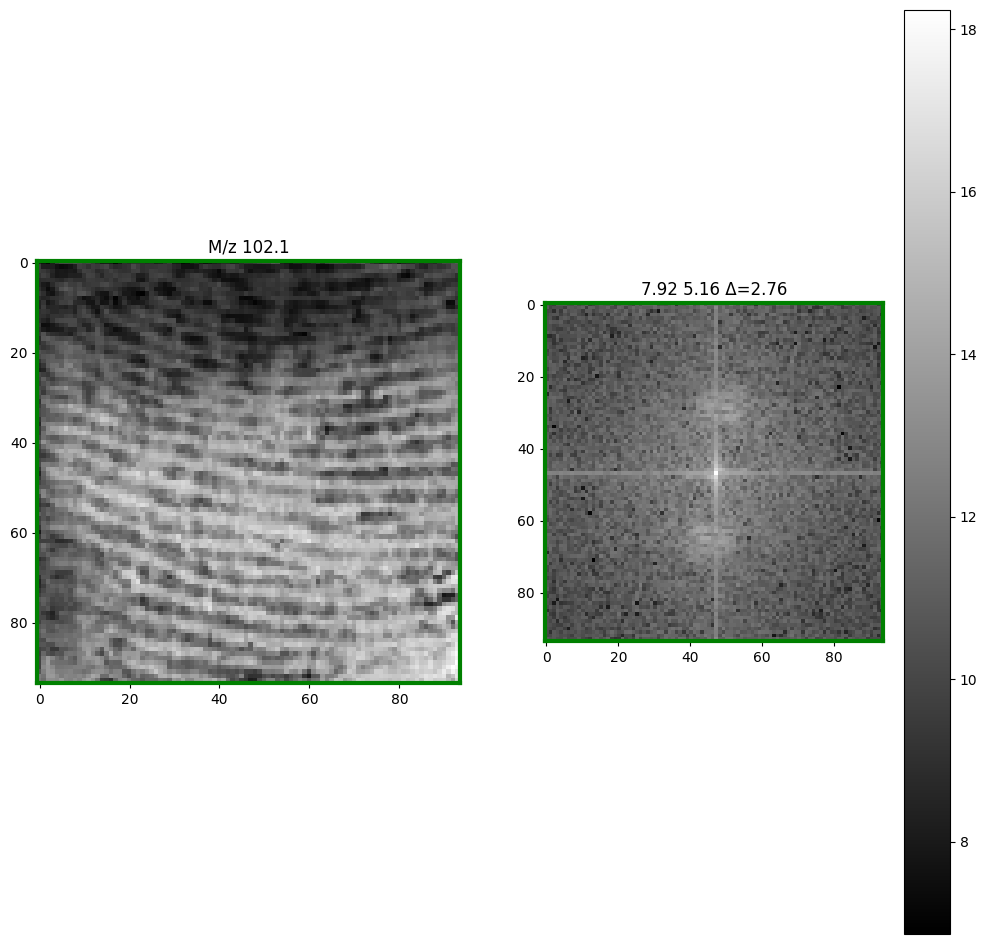

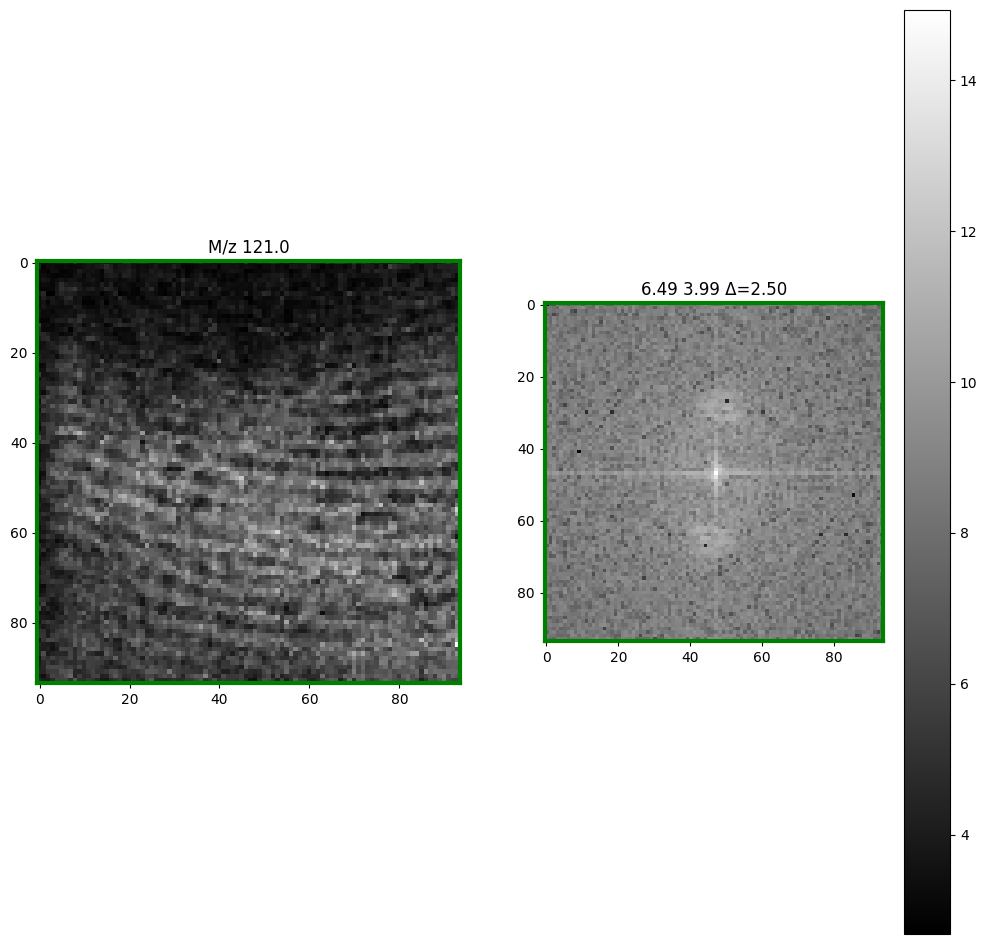

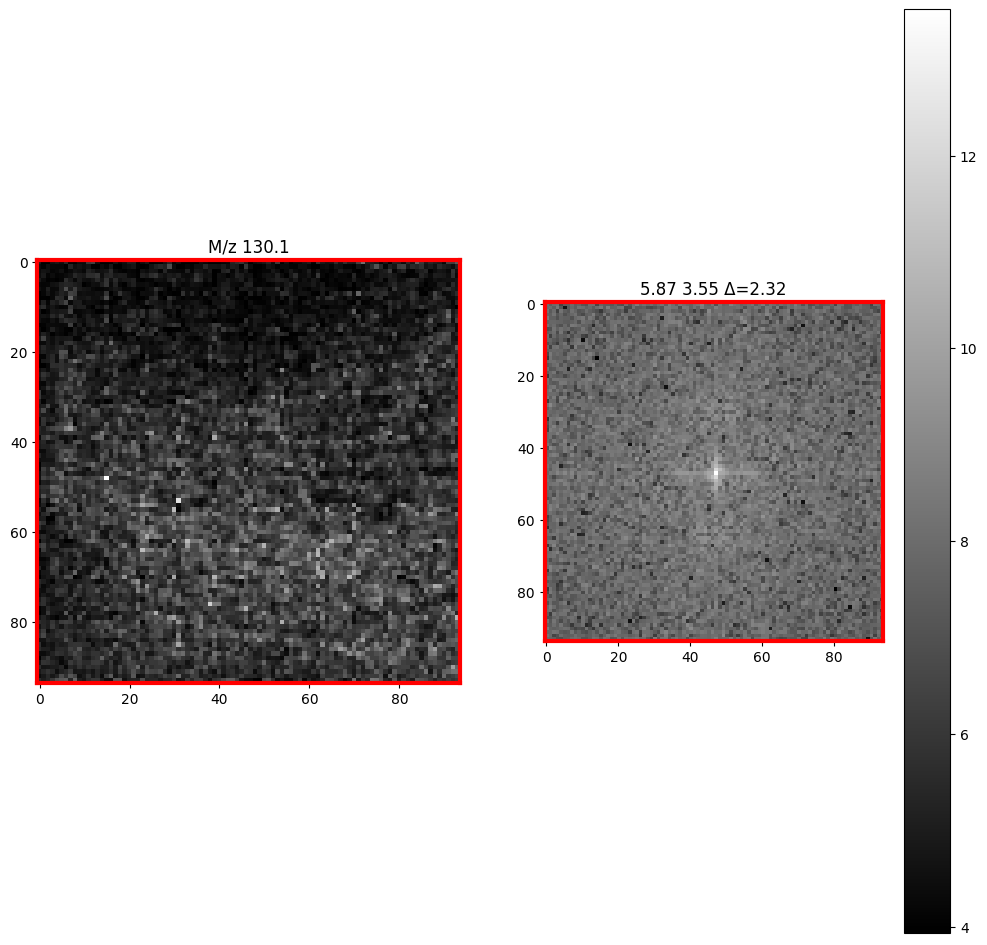

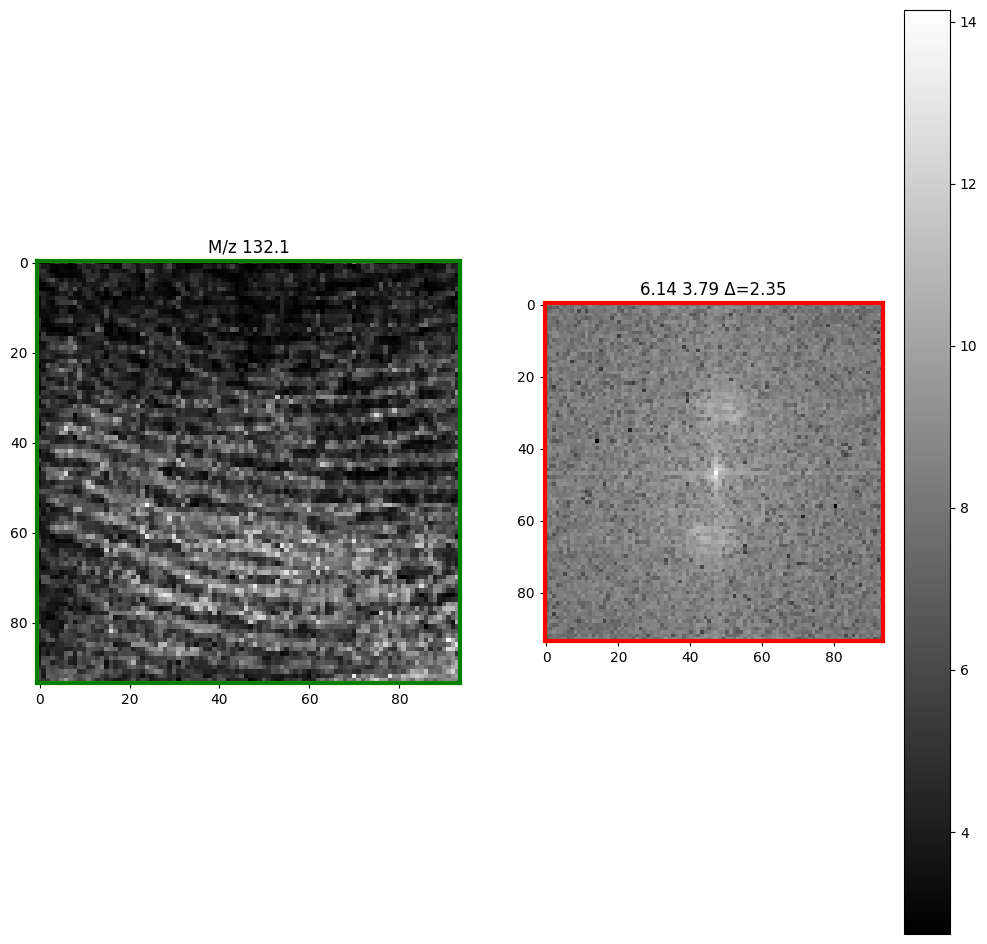

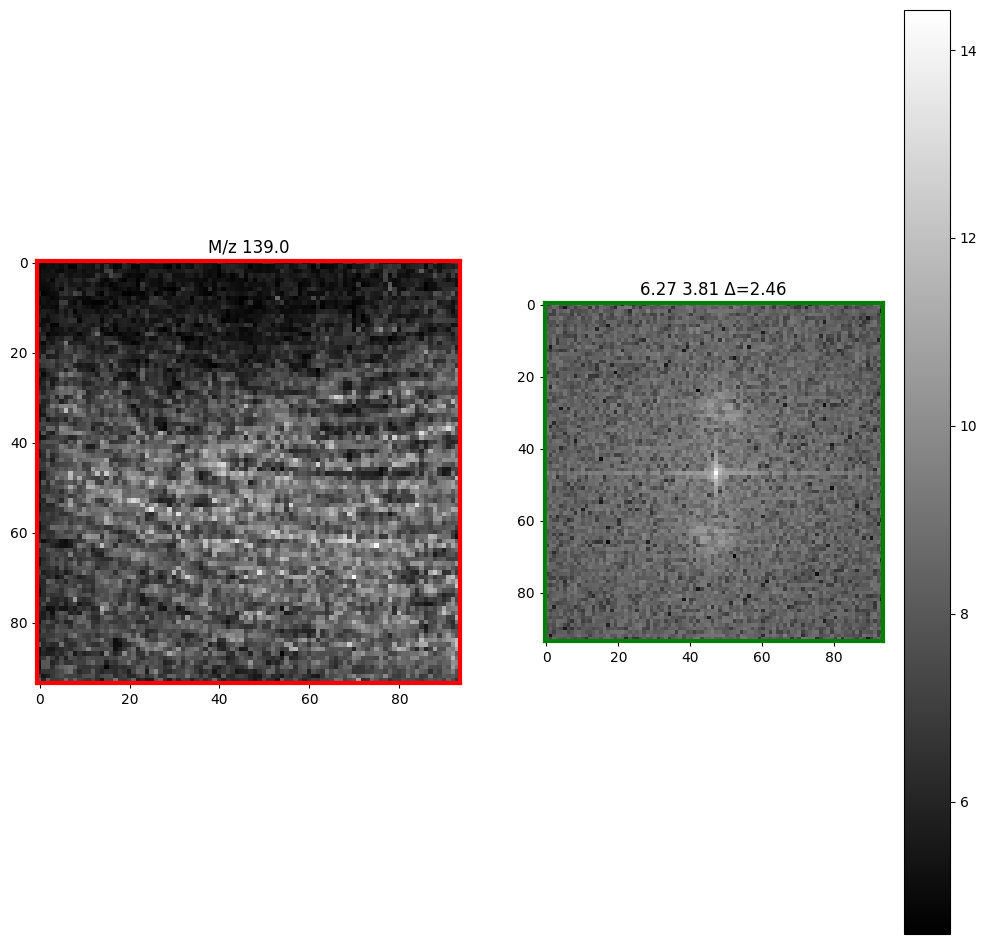

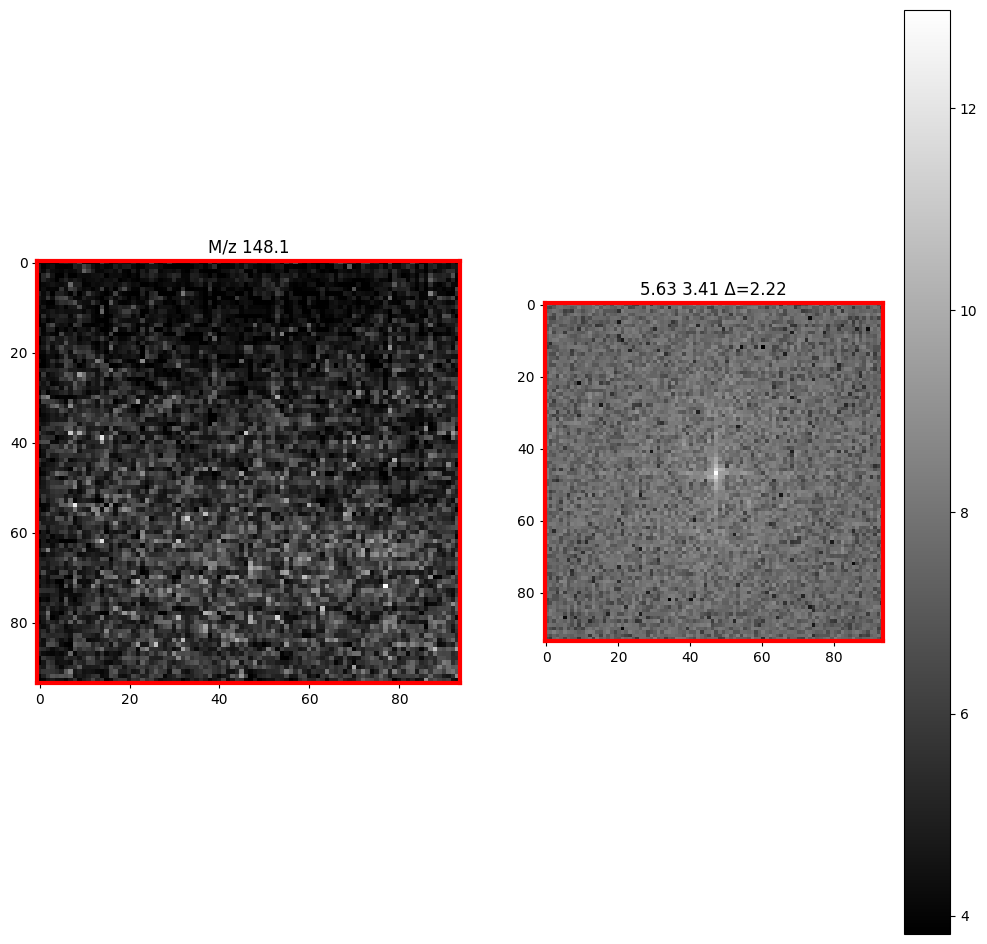

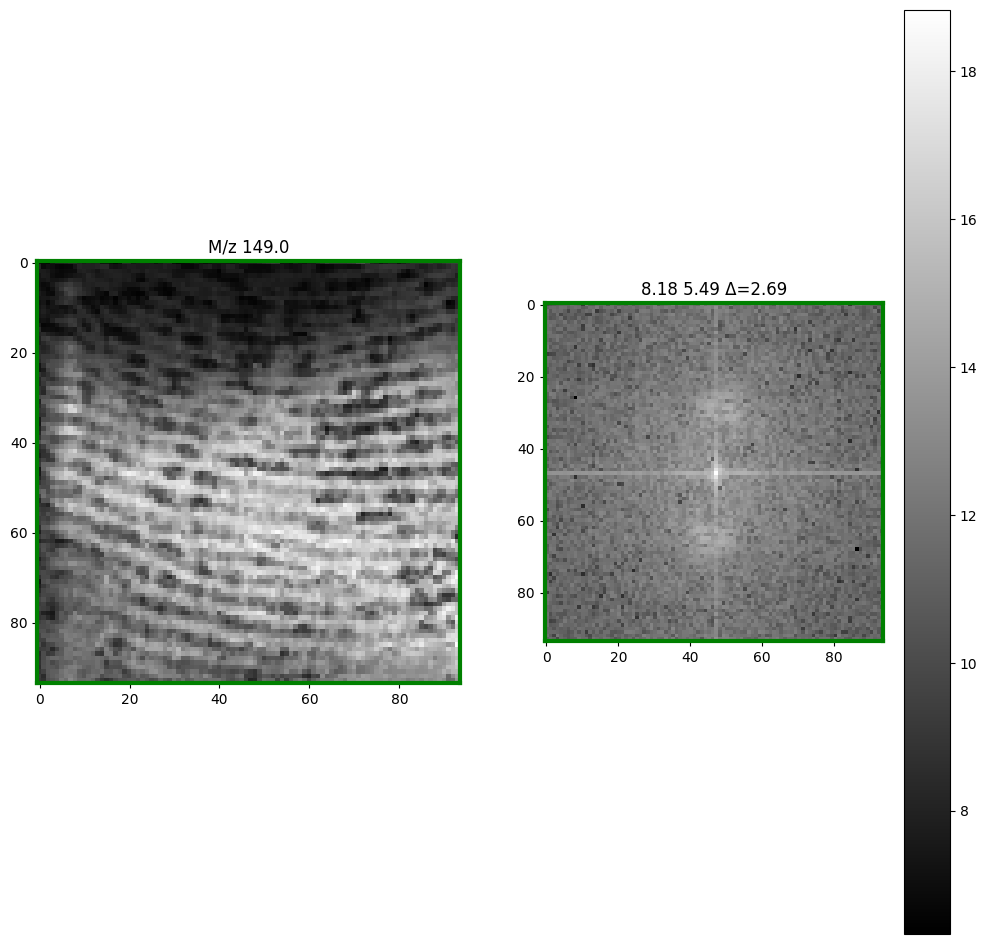

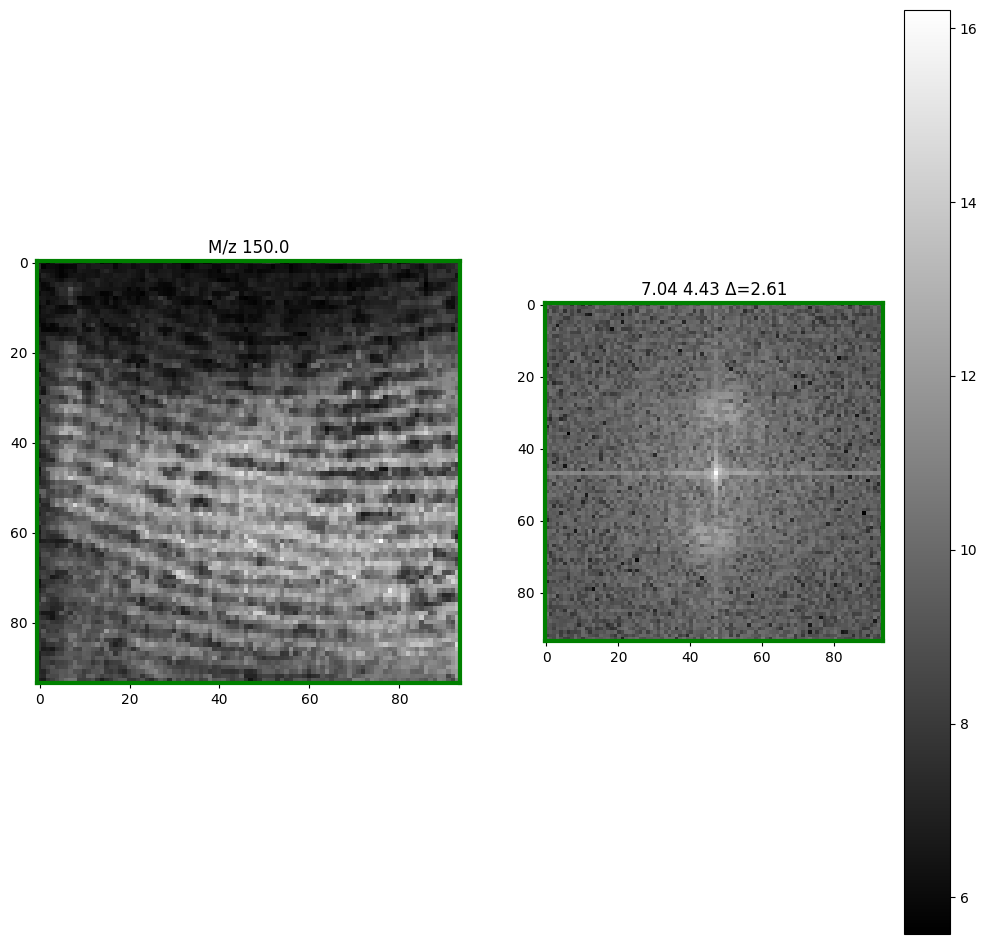

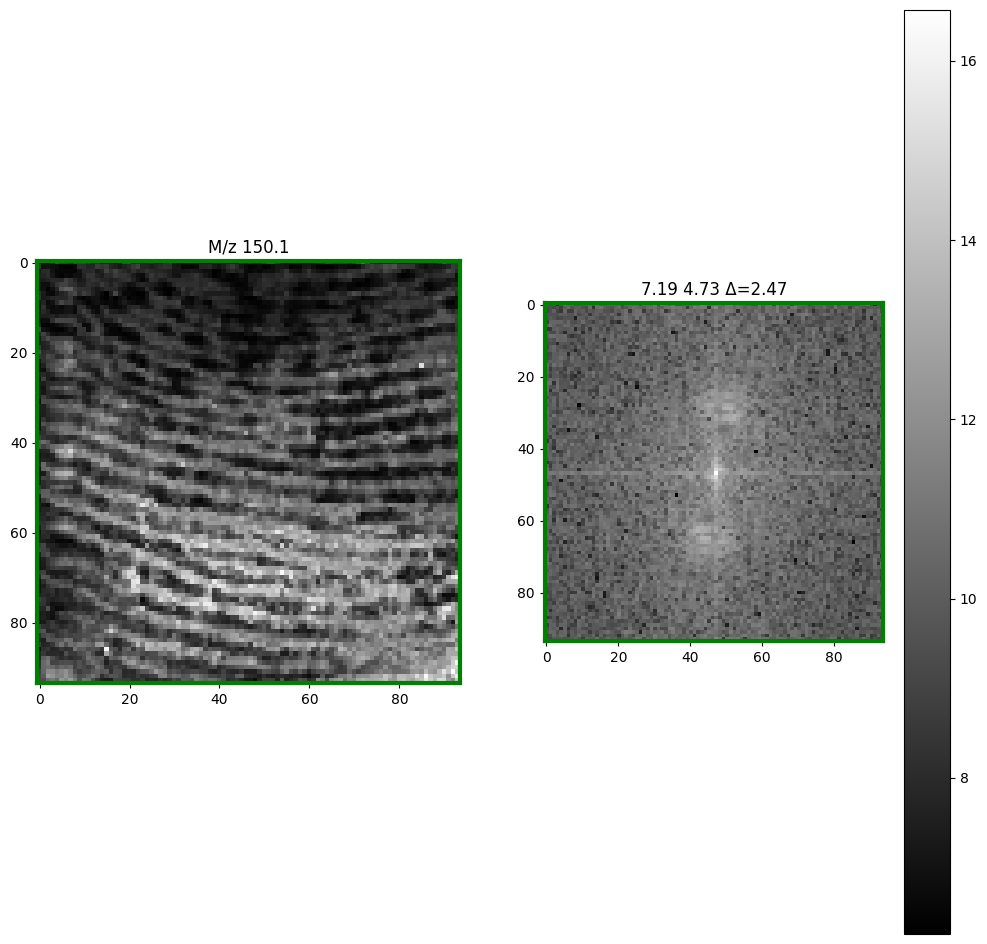

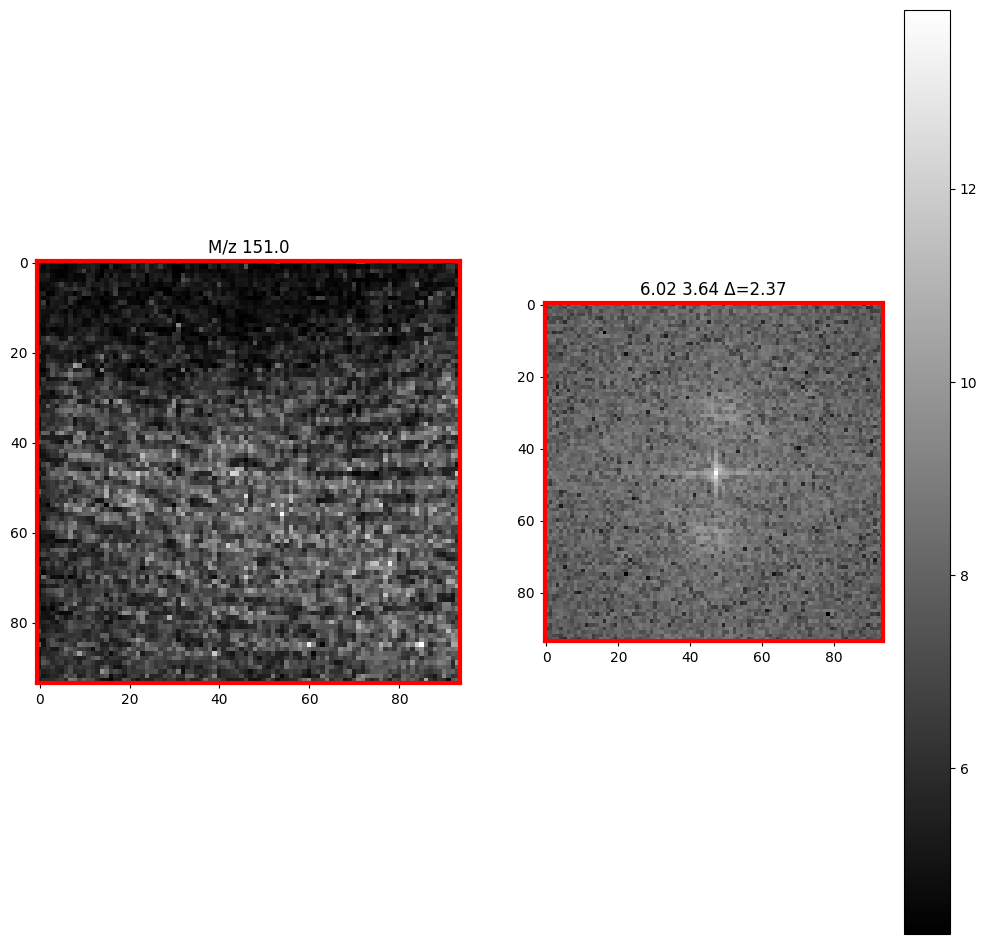

In [123]:
plot_img_and_fourier(X[1])

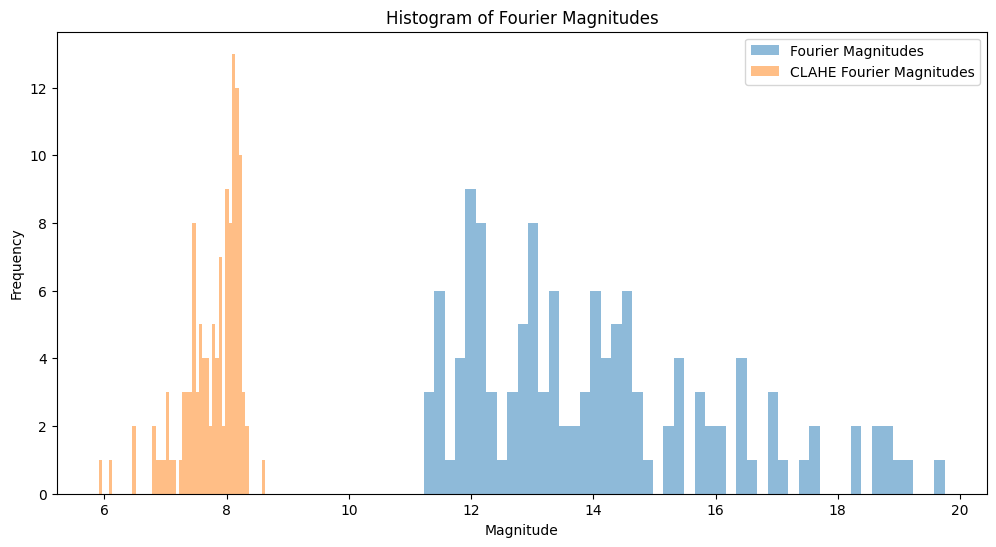

In [60]:
def get_max_fourier_magnitude(img: np.ndarray) -> float:
    fourier = np.fft.fft2(img)
    fourier_shifted = np.fft.fftshift(fourier)
    magnitude_spectrum = np.abs(fourier_shifted)
    return np.max(magnitude_spectrum)

fourier_magnitudes = []
clahe_fourier_magnitudes = []
for i in range(X.shape[-1]):
    max_fourier = get_max_fourier_magnitude(X[0, :, :, i])
    max_fourier_clahe =  get_max_fourier_magnitude(clahe(X[0, :, :, i]))

    fourier_magnitudes.append(np.log(max_fourier+1))
    clahe_fourier_magnitudes.append(np.log(max_fourier_clahe+1))

plt.figure(figsize=(12, 6))
plt.hist(fourier_magnitudes, bins=50, alpha=0.5, label='Fourier Magnitudes')
plt.hist(clahe_fourier_magnitudes, bins=50, alpha=0.5, label='CLAHE Fourier Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Fourier Magnitudes')
plt.legend()

## ML based garbage filtering

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
pos_dir = ROOT_DIR / Path('data/labeled/positive')
neg_dir = ROOT_DIR / Path('data/labeled/negative')

neg_files = os.listdir(neg_dir)
pos_files = os.listdir(pos_dir)

In [4]:
df_neg = pd.DataFrame({
    'img_name':neg_files,
    'label':0})

df_pos = pd.DataFrame({
    'img_name':pos_files,
    'label':1})

df = pd.concat([df_neg, df_pos], ignore_index=True)

In [5]:
def parse_image_stats(row):
    img_name = row['img_name']
    image_name_split = img_name.split('_')
    row['image_idx'] = image_name_split[1]
    row['channel'] = image_name_split[-1].split('.')[0]
    return row

df = df.apply(parse_image_stats, axis=1)
df.shape

(1896, 4)

In [6]:
neg_channels = set(df[df['label'] == 0]['channel'].unique())
pos_channels = set(df[df['label'] == 1]['channel'].unique())
pure_pos_channels = pos_channels - neg_channels
pure_neg_channels = neg_channels - pos_channels

print(f'{len(pure_pos_channels)=}')
print(f'{len(pure_neg_channels)=}')
print(f'{len(pos_channels)=}')
print(f'{len(neg_channels)=}')

len(pure_pos_channels)=0
len(pure_neg_channels)=74
len(pos_channels)=52
len(neg_channels)=126


In [7]:
# for every channel show how many times it got the pos label and how many times it got the neg label
channel_counts = df.groupby('channel')['label'].value_counts().unstack(fill_value=0)
channel_counts = channel_counts.rename(columns={0: 'neg_count', 1: 'pos_count'})
channel_counts['total_count'] = channel_counts['neg_count'] + channel_counts['pos_count']
channel_counts['pos_ratio'] = channel_counts['pos_count'] / channel_counts['total_count']
channel_counts['neg_ratio'] = channel_counts['neg_count'] / channel_counts['total_count']
channel_counts = channel_counts.sort_values(by='pos_ratio', ascending=False)
channel_counts.head(20)

label,neg_count,pos_count,total_count,pos_ratio,neg_ratio
channel,,,,,
40,6,12,18,0.666667,0.333333
95,7,12,19,0.631579,0.368421
8,6,10,16,0.625000,0.375000
57,4,6,10,0.600000,0.400000
41,8,10,18,0.555556,0.444444
94,4,5,9,0.555556,0.444444
58,7,8,15,0.533333,0.466667
93,9,7,16,0.437500,0.562500
71,9,6,15,0.400000,0.600000


In [8]:
neg_imgs = [np.array(Image.open(neg_dir / file)) for file in neg_files]
pos_imgs = [np.array(Image.open(pos_dir / file)) for file in pos_files]

In [9]:
y = np.array([0]*len(neg_imgs) + [1]*len(pos_imgs))
X = np.array(neg_imgs + pos_imgs)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.7, random_state=42,shuffle=True)

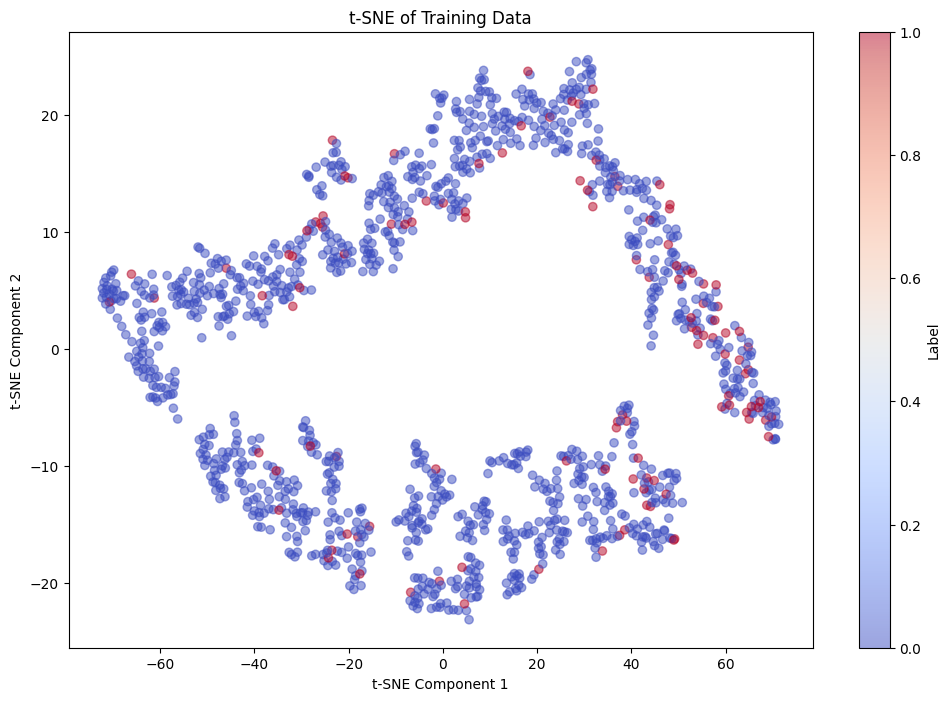

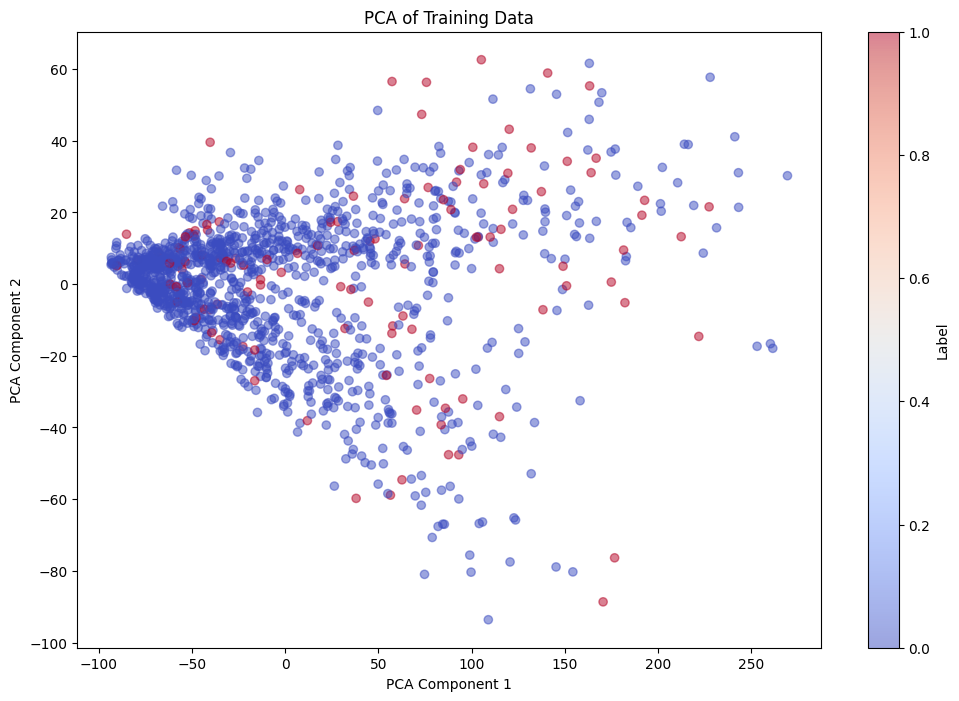

In [11]:
# plot TSNE of train and color by label
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_flatten = X_train.reshape(X_train.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_flatten)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)
plt.figure(figsize=(12, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Label')
plt.title('t-SNE of Training Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Label')
plt.title('PCA of Training Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [21]:
X_train.shape

(1327, 94, 94)

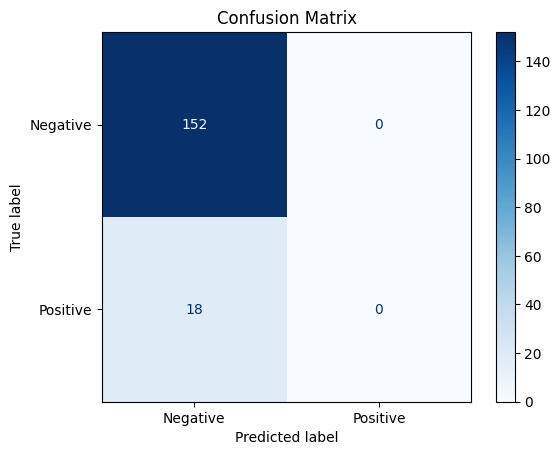

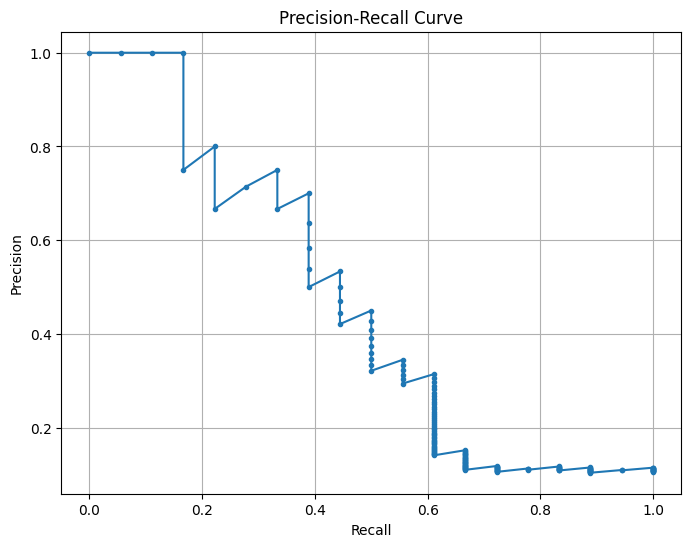

In [23]:
# train a simple SVM classifier on the data
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_val_flatten = X_val.reshape(X_val.shape[0], -1)
pipeline = make_pipeline(StandardScaler(), SVC(random_state=42))
pipeline.fit(X_train_flatten, y_train)
y_pred = pipeline.predict(X_val_flatten)

# plot confusion matrix and PR curve

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
precision, recall, _ = precision_recall_curve(y_val, pipeline.decision_function(X_val_flatten))
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


In [ ]:
# extract the embeddings of all images in the training set using resnet 50

# Labeling Fingerprints

In [2]:
import os
from pathlib import Path
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image
from typing import List, Tuple, Optional, Callable, Iterator
import cv2
import numpy as np


In [3]:
X =  np.load(f'{ROOT_DIR}/data/proccessed/X.npy')
y =  np.load(f'{ROOT_DIR}/data/proccessed/y.npy')
masses=  np.load(f'{ROOT_DIR}/data/proccessed/masses.npy')
assert X.shape[0] == y.shape[0], "X and y must have the same number of samples"



In [4]:
BASE_DIR = Path(f'{ROOT_DIR}/data/labeled')

IMAGE_FILE_TYPE = 'png'  


def ensure_dirs(base_dir:Path =BASE_DIR)-> Tuple[Path, Path]:
    pos_dir = Path(base_dir) / "positive"
    neg_dir = Path(base_dir) / "negative"
    pos_dir.mkdir(parents=True, exist_ok=True)
    neg_dir.mkdir(parents=True, exist_ok=True)
    return pos_dir, neg_dir

def normalize_image(img: np.ndarray) -> np.ndarray:
    mi, ma = float(img.min()), float(img.max())
    if ma > mi:
        norm = (img - mi) / (ma - mi) * 255.0
    else:
        norm = np.zeros_like(img)
    return norm.astype(np.uint8)


def preprocess_image(
    img: np.ndarray,
    size: Tuple[int, int] = (300, 300),
    clip_limit: float = 2.0,
    tile_grid_size: Tuple[int, int] = (8, 8)
) -> np.ndarray:
    """
    1. Normalize raw floats to 0–255 uint8
    2. Convert to single-channel if needed
    3. Resize to `size`
    4. Apply CLAHE
    5. Return float32 image in [0,1]
    """
    # 1. Scale floats → 0–255
    uint8_img = normalize_image(img)
    
    # 2. Ensure single‑channel
    if uint8_img.ndim == 3 and uint8_img.shape[2] > 1:
        uint8_img = cv2.cvtColor(uint8_img, cv2.COLOR_BGR2GRAY)
    
    # 3. Resize
    resized = cv2.resize(uint8_img, size, interpolation=cv2.INTER_LINEAR)
    
    # 4. CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_img = clahe.apply(resized)
    
    # 5. Back to uint8 for display
    return clahe_img.astype(np.uint8)


def is_already_labeled(name: str, pos_dir: Path, neg_dir: Path) -> bool:
    return (pos_dir/f"{name}.{IMAGE_FILE_TYPE}").exists() or (neg_dir/f"{name}.{IMAGE_FILE_TYPE}").exists()

def save_image(img: np.ndarray, name: str, target_dir: Path):
    uint8_img = normalize_image(img)
    Image.fromarray(uint8_img).save(target_dir / f"{name}.{IMAGE_FILE_TYPE}")

In [5]:
def get_image(X: np.ndarray, index: Tuple[int, int]) -> np.ndarray:
    first_index, second_index = index
    if first_index >= X.shape[0] or second_index >= X.shape[-1]:
        raise IndexError("Index out of bounds for the image array.")
    return X[first_index, :, :, second_index]

def get_image_name(index: Tuple[int, int]) -> str:
    first_index, second_index = index
    return f"image_{first_index}_channel_{second_index}"

def random_channel_iterator(X: np.ndarray) -> Iterator[Tuple[int, int]]:
    while True:
        first_index = np.random.randint(0, X.shape[0])
        second_index = np.random.randint(0, X.shape[-1])
        yield first_index, second_index

In [6]:
def build_widgets(
    on_pos: Callable[[], None],
    on_neg: Callable[[], None],
    on_skip: Callable[[], None],
    on_exit: Callable[[], None]
) -> Tuple[widgets.Output, widgets.HBox]:
    bpos  = widgets.Button(description="Positive", button_style='success')
    bneg  = widgets.Button(description="Negative", button_style='danger')
    bskip = widgets.Button(description="Skip")
    bexit = widgets.Button(description="Exit", button_style='warning')
    bpos.on_click(lambda _: on_pos())
    bneg.on_click(lambda _: on_neg())
    bskip.on_click(lambda _: on_skip())
    bexit.on_click(lambda _: on_exit())
    out = widgets.Output()
    controls = widgets.HBox([bpos, bneg, bskip, bexit])
    return out, controls



def label_images(X: np.ndarray, base_dir: Path = BASE_DIR):
    indices: Iterator[Tuple[int, int]] = random_channel_iterator(X)
    pos_dir, neg_dir = ensure_dirs(base_dir)
    it = iter(indices)
    current: Optional[Tuple[int,int]] = None
    exited = False

    def on_exit() -> None:
        nonlocal exited
        exited = True
        out.clear_output(wait=True)
        clear_output(wait=True)
        print("Labeling exited by user.")

    out, controls = build_widgets(
        on_pos=lambda: on_label("pos"),
        on_neg=lambda: on_label("neg"),
        on_skip=lambda: on_label(None),
        on_exit=on_exit
    )

    def show_next() -> None:
        nonlocal current
        if exited:
            return
        clear_output(wait=True)
        out.clear_output(wait=True)        # find next unlabeled
        while True:
            try:
                idx = next(it)
            except StopIteration:
                print("All images labeled or skipped.")
                return
            name = get_image_name(idx)
            if not is_already_labeled(name, pos_dir, neg_dir):
                current = idx
                break
        img = get_image(X, current)
        pil = Image.fromarray(preprocess_image(img))
        with out:
            display(pil)
        display(out, controls)

    def on_label(label: Optional[str]) -> None:
        nonlocal current
        if exited or current is None:
            return
        name = get_image_name(current)
        if label == "pos":
            save_image(get_image(X, current), name, pos_dir)
        elif label == "neg":
            save_image(get_image(X, current), name, neg_dir)
        show_next()

    show_next()

In [23]:
label_images(X)

Output()

In [12]:
len(os.listdir(BASE_DIR / "positive")), len(os.listdir(BASE_DIR / "negative"))

(38, 313)

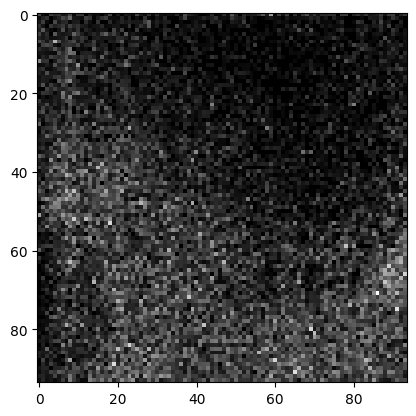

In [8]:
plt.imshow(X[58, :, :, 25], cmap='gray')

# CNN

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
X = np.load('data/proccessed/X.npy')
y = np.load('data/proccessed/y.npy').reshape(-1,1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
import os
if not os.path.exists('data/pretrained'):
    os.makedirs('data/pretrained')
if os.path.exists('data/pretrained/effnetv2s.weights.h5'):
    print('Pretrained weights already exist, loading weights.')
    # load the pretrained weights
    effnet = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights=None,
        # weights='data/pretrained/effnetv2s.weights.h5',
        input_tensor=None,
        input_shape=(94, 94, 3),
        pooling='avg',
        include_preprocessing=True
    )
else:
    print('Downloading pretrained weights...')
    effnet = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(94, 94, 3),
        pooling='avg',
        include_preprocessing=True
    )
    effnet.save_weights('data/pretrained/effnetv2s.weights.h5')
# effnet.trainable = False  # Freeze the base model
model = tf.keras.Sequential([
    Input(shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(3,(1,1),padding='same',activation='linear'),
    effnet,
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Lambda(lambda x: x * 80)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()
history = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_data=(X_val, y_val))

Pretrained weights already exist, loading weights.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 3)      │           381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,333,022 (77.56 MB)

 Trainable params: 20,179,150 (76.98 MB)

 Non-trainable params: 153,872 (601.06 KB)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 390s 5s/step - loss: 1113.9319 - mae: 27.7307 - val_loss: 1478.4534 - val_mae: 32.2177
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - loss: 909.1914 - mae: 22.8978 - val_loss: 735.3842 - val_mae: 22.8871
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - loss: 736.3708 - mae: 22.5289 - val_loss: 922.9512 - val_mae: 26.2106
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 578.2556 - mae: 21.2132 - val_loss: 1328.7800 - val_mae: 31.2133
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - loss: 583.0987 - mae: 20.0141 - val_loss: 1131.3159 - val_mae: 28.8154
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - loss: 548.9597 - mae: 19.8954 - val_loss: 850.8111 - val_mae: 24.8970
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - loss: 631.8997 - mae: 21.5867 - val_loss: 763.6957 - val_mae: 23.1060
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - loss: 583.4959 - mae: 21.7754 - val_loss: 810.7091 - val_mae: 23.3173
Epoch 

Text(0.5, 1.0, 'True vs Predicted R2=-2.14')

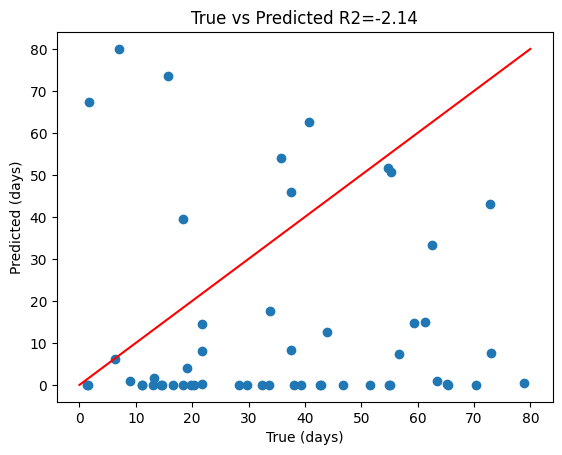

In [10]:
y_pred = model(X_val)
y_pred = y_pred.numpy().flatten()
y_val = y_val.flatten()
import matplotlib.pyplot as plt
plt.scatter(y_val,y_pred)
plt.xlabel('True (days)')
plt.ylabel('Predicted (days)')
plt.plot([0,80],[0,80],color='red')
from sklearn.metrics import r2_score
score = r2_score(y_val,y_pred)
plt.title(f'True vs Predicted R2={score:.2f}')


# ML

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
X = np.load('../data/processed/X.npy')
y = np.load('../data/processed/y.npy')
metadata = pd.read_csv('../data/processed/metadata.csv')

X = X.reshape(X.shape[0], -1)  # Flatten the images for ML

In [10]:
train_val_ratio = 0.7
#shuffle metadata
metadata = metadata.sample(frac=1, random_state=42).reset_index(drop=True)
# Get unique slide IDs
train_slides = metadata['slide_id'].unique()[:int(len(metadata['slide_id'].unique()) * train_val_ratio)]
val_slides = metadata['slide_id'].unique()[int(len(metadata['slide_id'].unique()) * train_val_ratio):]

train_indices = metadata[metadata['slide_id'].isin(train_slides)].index
val_indices = metadata[metadata['slide_id'].isin(val_slides)].index

X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

In [11]:
scalar = StandardScaler().fit(X_train)
X_train_scale = scalar.transform(X_train)
X_val_scale = scalar.transform(X_val)

In [12]:
pca = PCA(n_components=0.995)
X_train_pca = pca.fit_transform(X_train_scale)
X_val_pca = pca.transform(X_val_scale)

np.float64(0.6510485082094317)

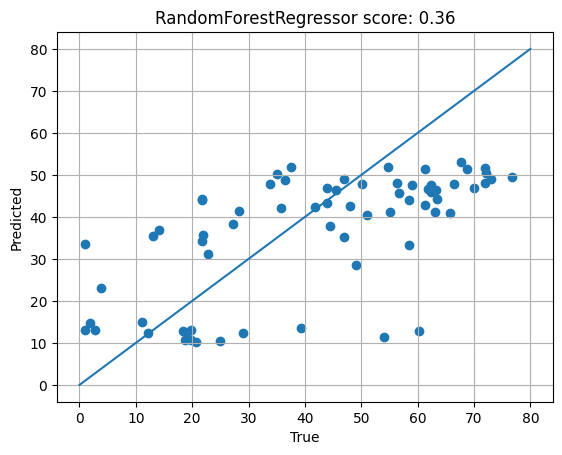

In [13]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100,random_state=42,max_depth=3,n_jobs=-1)

model.fit(X_train_pca,y_train)
score = model.score(X_val_pca,y_val)

y_pred = model.predict(X_val_pca)
plt.scatter(y_val,y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'{model.__class__.__name__} score: {score:.2f}')
plt.grid()
plt.plot([0,80],[0,80])
np.corrcoef(y_val,y_pred)[0,1]

np.float64(0.8143125916194662)

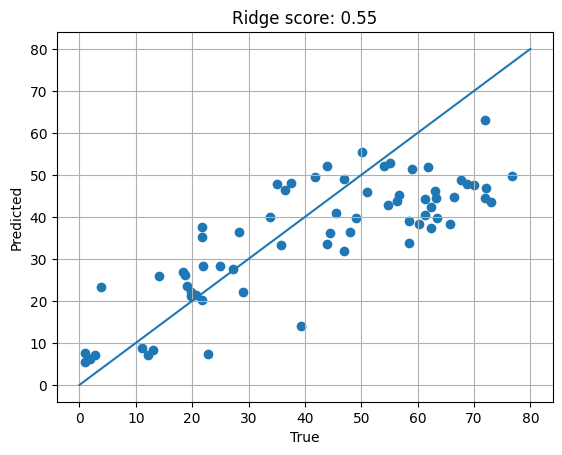

In [7]:
from sklearn.linear_model import Ridge

model = Ridge().fit(X_train_pca,y_train)

model.fit(X_train_pca,y_train)
score = model.score(X_val_pca,y_val)

y_pred = model.predict(X_val_pca)
plt.scatter(y_val,y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'{model.__class__.__name__} score: {score:.2f}')
plt.grid()
plt.plot([0,80],[0,80])
np.corrcoef(y_val,y_pred)[0,1]

np.float64(0.6206637654896427)

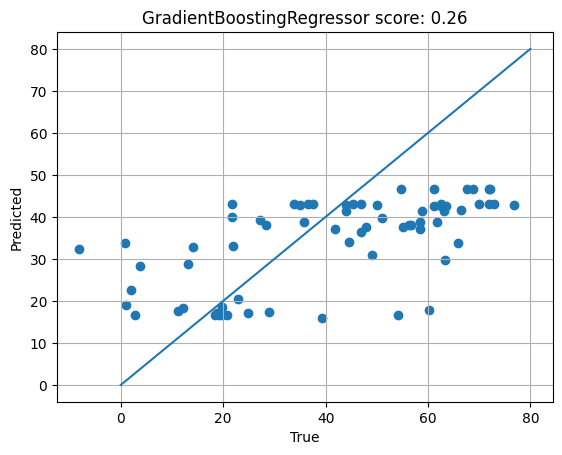

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=10,max_depth=3,random_state=321)

model.fit(X_train_pca,y_train)
score = model.score(X_val_pca,y_val)

y_pred = model.predict(X_val_pca)
plt.scatter(y_val,y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'{model.__class__.__name__} score: {score:.2f}')
plt.grid()
plt.plot([0,80],[0,80])
np.corrcoef(y_val,y_pred)[0,1]

np.float64(0.6257388835667727)

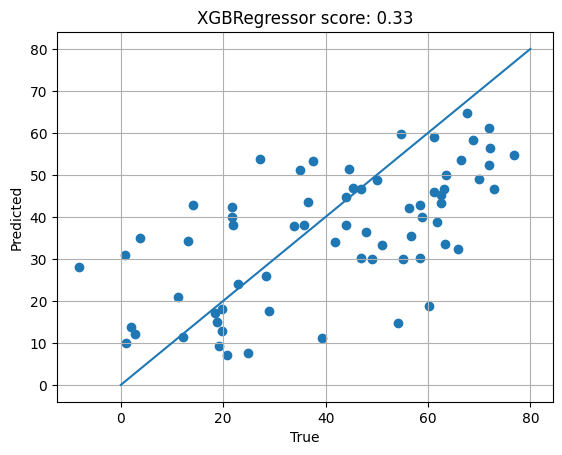

In [15]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100,max_depth=3,random_state=42)

model.fit(X_train_pca,y_train)
score = model.score(X_val_pca,y_val)

y_pred = model.predict(X_val_pca)
plt.scatter(y_val,y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'{model.__class__.__name__} score: {score:.2f}')
plt.grid()
plt.plot([0,80],[0,80])
np.corrcoef(y_val,y_pred)[0,1]

np.float64(0.7101783615407159)

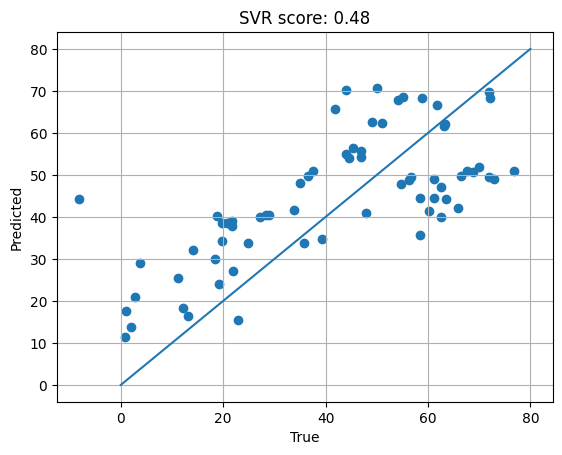

In [17]:
from sklearn.svm import SVR

model = SVR(kernel='rbf',C=200,epsilon=0.1)

model.fit(X_train_pca,y_train)
score = model.score(X_val_pca,y_val)

y_pred = model.predict(X_val_pca)
plt.scatter(y_val,y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'{model.__class__.__name__} score: {score:.2f}')
plt.grid()
plt.plot([0,80],[0,80])
np.corrcoef(y_val,y_pred)[0,1]

np.float64(0.7985298034579374)

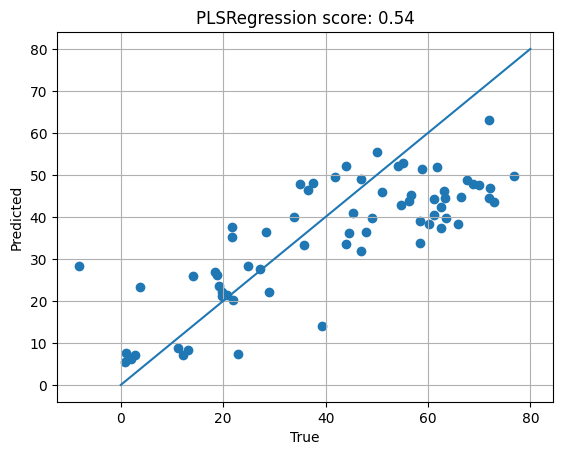

In [20]:
# PLS
from sklearn.cross_decomposition import PLSRegression
model = PLSRegression(n_components=1)

model.fit(X_train_pca,y_train)
score = model.score(X_val_pca,y_val)

y_pred = model.predict(X_val_pca)
plt.scatter(y_val,y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'{model.__class__.__name__} score: {score:.2f}')
plt.grid()
plt.plot([0,80],[0,80])
np.corrcoef(y_val,y_pred)[0,1]

Text(0.5, 1.0, 'PLS Component 1 vs Target (Validation)')

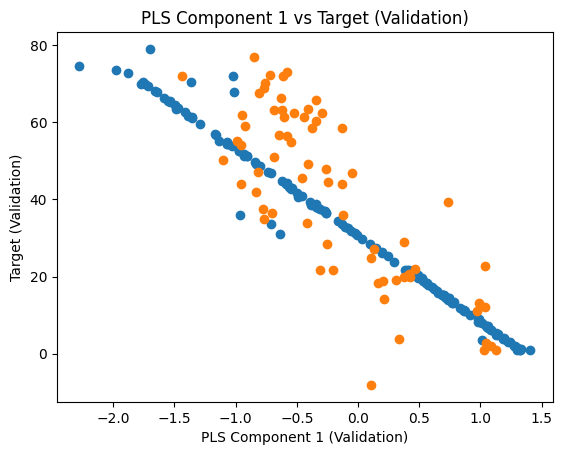

In [22]:
# plot the first component of the PLS against the target
plt.scatter(model.x_scores_[:, 0], y_train)
plt.xlabel('PLS Component 1')
plt.ylabel('Target')
plt.title('PLS Component 1 vs Target')

# plot the first component of the PLS against the target in the validation set
pls1_val = model.transform(X_val_pca)
plt.scatter(pls1_val[:, 0], y_val)
plt.xlabel('PLS Component 1 (Validation)')
plt.ylabel('Target (Validation)')
plt.title('PLS Component 1 vs Target (Validation)')